In [1]:
from pygrounds.utils import S3Utils, DSWarehouse
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate

In [3]:
query = \
"""
  SELECT
DISTINCT merged_eligibility.gr_lookup_id AS pid,
         2020 - year_of_birth AS age
    FROM `grnds-frankie.covid_guidance_engine.amazon__worksite_eligiblity` AS worksite_eligibility
    JOIN `national-claims-warehouse.bronze.merged_eligibility` AS merged_eligibility
      ON worksite_eligibility.gr_lookup_id = merged_eligibility.gr_lookup_id
   WHERE merged_eligibility.gr_lookup_id_type = 'pid'
"""

In [4]:
dsw = DSWarehouse()
age_distribution = dsw.query_to_df(query)

In [5]:
age_distribution.to_csv('amazon_age_distribution.csv')

### Note: switch to pyseir env before running following codes.

In [6]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
import numpy as np
import dill as pickle
from pyseir.inference import model_fitter
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate
from pyseir import load_data
#from pyseir.inference.whitelist_generator import WhitelistGenerator
from pyseir.utils import get_run_artifact_path, RunArtifact
#from pyseir.ensembles.ensemble_runner import EnsembleRunner
from pyseir.utils import get_run_artifact_path, RunArtifact, RunMode
from pyseir.deployment.demographic_mapper import DemographicMapper, CovidMeasure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def load_inference_results(fips):
    """
    This function will be added to pyseir soon. 
    """
    model_path = get_run_artifact_path(fips, RunArtifact.MLE_FIT_MODEL)
    model = pickle.loads(open(model_path, 'rb').read())

    fit_results_path = get_run_artifact_path(fips, RunArtifact.MLE_FIT_RESULT)
    with open(fit_results_path) as f:
        fit_results = json.load(f)
    fit_results = pd.DataFrame(fit_results).set_index('fips').loc[fips].to_dict()
    return model, fit_results

#### Run inference for CA

In [2]:
model_fitter.run_state(state='California', 
                       states_only=True, 
                       with_age_structure=True)

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


------------------------------------------------------------------
| FCN = 72.9                    |     Ncalls=421 (423 total)     |
| EDM = 0.149 (Goal: 5E-06)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------


In [8]:
# get target age distribution pdf
age_distribution = pd.read_csv('amazon_age_distribution.csv')
age_counts = age_distribution.age.value_counts().sort_index() \
                    .rename('count') \
                    .reset_index().rename(columns={'index': 'age'})
age_counts['pmf'] = age_counts['count'] / age_counts['count'].sum()
age_distribution = scipy.interpolate.interp1d(np.append(age_counts['age'], 120), 
                                              np.append(age_counts['pmf'], 0))

In [22]:
measure_units = ['per_capita', 'per_capita_day']
measures = ['IHR', 'IHR_icu', 'IFR']

In [27]:
for fips in ['06']:
    model, fit_results = load_inference_results(fips)
    dm = DemographicMapper(fips=fips,
                      mle_model=model,
                      fit_results=fit_results,
                      measure_units=measure_units,
                      measures=measures,
                      target_age_distribution_pdf=age_distribution)
    results = dm.run()

/Users/xzhang/Documents/covid/covid-data-model/pyseir/deployment/demographic_mapper.py:240: RuntimeWarning: divide by zero encountered in true_divide
  frac_no_access_to_icu = (self.predictions['HICU'] - self.parameters['beds_ICU']) / self.predictions['HICU']
/Users/xzhang/Documents/covid/covid-data-model/pyseir/deployment/demographic_mapper.py:252: RuntimeWarning: divide by zero encountered in true_divide
  frac_no_access_to_hgen = (self.predictions['HGen'] - self.parameters['beds_general']) / self.predictions['HGen']


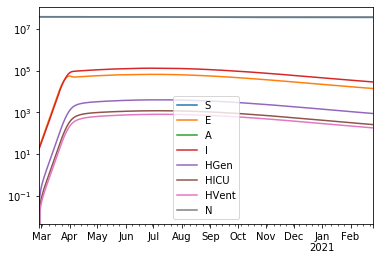

In [28]:
results['compartments'].plot()
plt.yscale('log')

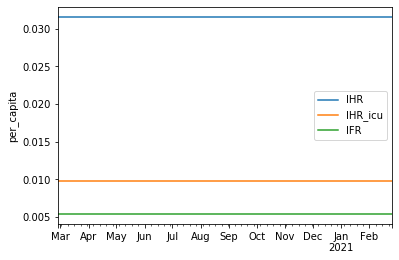

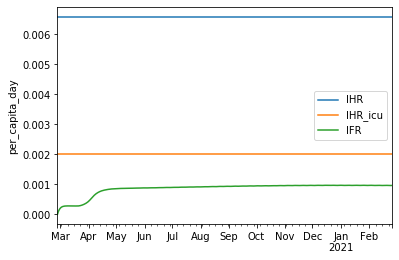

In [29]:
for unit in measure_units:
    plt.figure()
    for measure in measures:
        results[measure][unit].plot(label=measure)
    plt.ylabel(unit)
    plt.legend()